# Intraday
In this notebook we use Alphalens to analyse the performance of an intraday factor, which is computed daily but the stocks are bought at marker open and sold at market close with no overnight positions.

In [4]:
%pylab inline --no-import-all
import yfinance as yf
import alphalens
import pandas as pd
import numpy as np
import datetime

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-17", end="2021-05-17")
# tech = data[["Open"]]

[*********************100%***********************]  20 of 20 completed


In [7]:
today_open = pan['Open']
today_close = pan['Close']
yesterday_close = today_close.shift(1)

In [8]:
factor = (today_open - yesterday_close) / yesterday_close

In [9]:
# Fix time as Yahoo doesn't set it
today_open.index += pd.Timedelta('9h30m')
today_close.index += pd.Timedelta('16h')
# pricing will contain both open and close
pricing = pd.concat([today_open, today_close]).sort_index()

In [11]:
pricing.head()

,AAPL,ADBE,AMZN,CSCO,FB,GOOGL,HPQ,IBM,INTC,MSFT,NFLX,NVDA,PYPL,QCOM,T,TSLA,UBER,V,VZ,XLNX
Date,,,,,,,,,,,,,,,,,,,,
2011-05-16 09:30:00,12.114286,35.130001,200.539993,16.820000,NaN,263.418427,18.256130,169.809998,23.320000,24.959999,35.142857,18.209999,NaN,57.180000,31.320000,5.598000,NaN,19.787500,37.259998,35.580002
2011-05-16 16:00:00,11.903571,34.389999,192.509995,16.600000,NaN,259.469482,18.074478,168.860001,23.639999,24.570000,33.869999,17.700001,NaN,56.700001,31.059999,5.320000,NaN,19.985001,36.970001,35.369999
2011-05-17 09:30:00,11.857143,34.389999,191.820007,16.500000,NaN,257.972961,17.061762,167.850006,23.370001,24.400000,33.571430,17.639999,NaN,56.380001,31.020000,5.400000,NaN,19.950001,36.900002,35.230000
2011-05-17 16:00:00,12.005000,34.720001,194.809998,16.639999,NaN,265.495483,16.762035,170.500000,23.549999,24.520000,33.848572,17.629999,NaN,56.349998,31.120001,5.192000,NaN,20.150000,37.110001,35.279999
2011-05-18 09:30:00,12.016786,34.599998,194.130005,16.639999,NaN,265.035034,16.634876,170.100006,23.600000,24.530001,33.914288,17.700001,NaN,56.230000,31.160000,5.220000,NaN,20.107500,37.169998,35.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12 16:00:00,122.769997,472.089996,3151.939941,51.599998,302.549988,2200.250000,31.950001,141.300003,53.619999,239.000000,484.980011,550.340027,239.910004,124.620003,31.969999,589.890015,43.810001,220.630005,58.410000,116.870003
2021-05-13 09:30:00,124.580002,478.010010,3185.469971,52.110001,306.079987,2226.120117,32.000000,141.449997,54.040001,241.800003,489.130005,561.349976,241.919998,127.120003,31.830000,601.539978,44.990002,221.509995,58.000000,118.779999
2021-05-13 16:00:00,124.970001,474.160004,3161.469971,52.490002,305.260010,2229.040039,32.389999,144.169998,54.009998,243.029999,486.660004,546.609985,240.800003,127.110001,32.209999,571.690002,44.480000,223.740005,58.810001,114.610001


In [12]:
# Align factor to open price
factor.index += pd.Timedelta('9h30m')
factor = factor.stack()
factor.index = factor.index.set_names(['date', 'asset'])

In [13]:
factor.unstack().head()

asset,AAPL,ADBE,AMZN,CSCO,FB,GOOGL,HPQ,IBM,INTC,MSFT,NFLX,NVDA,PYPL,QCOM,T,TSLA,UBER,V,VZ,XLNX
date,,,,,,,,,,,,,,,,,,,,
2011-05-17 09:30:00,-0.003900,0.000000,-0.003584,-0.006024,NaN,-0.005768,-0.056030,-0.005981,-0.011421,-0.006919,-0.008815,-0.003390,NaN,-0.005644,-0.001288,0.015038,NaN,-0.001751,-0.001893,-0.003958
2011-05-18 09:30:00,0.000982,-0.003456,-0.003491,0.000000,NaN,-0.001734,-0.007586,-0.002346,0.002123,0.000408,0.001941,0.003971,NaN,-0.002130,0.001285,0.005393,NaN,-0.002109,0.001617,0.001701
2011-05-19 09:30:00,0.006503,0.003155,0.006292,0.006006,NaN,0.005511,-0.001644,0.002464,-0.023451,0.006480,0.003958,0.007760,NaN,0.003011,0.002564,0.025806,NaN,0.001500,0.002696,0.000551
2011-05-20 09:30:00,-0.002849,0.001412,-0.004276,0.001201,NaN,0.001035,-0.003321,-0.001114,-0.003399,0.000000,-0.004738,-0.002250,NaN,-0.001396,-0.001592,0.002128,NaN,-0.003767,-0.001876,-0.001387
2011-05-23 09:30:00,-0.015661,-0.016709,-0.015555,-0.007260,NaN,-0.014179,-0.011117,-0.009285,-0.012920,-0.011433,-0.011712,-0.014373,NaN,-0.015511,-0.010217,-0.012513,NaN,-0.014573,-0.010767,-0.012021


In [15]:
sector_names = {
    0 : "information_technology",
#     1 : "financials",
#     2 : "health_care",
#     3 : "industrials",
#     4 : "utilities", 
#     5 : "real_estate", 
#     6 : "materials", 
#     7 : "telecommunication_services", 
#     8 : "consumer_staples", 
#     9 : "consumer_discretionary", 
#     10 : "energy" 
}

# ticker_sector = {
#     "ACN" : 0, "ATVI" : 0, "ADBE" : 0, "AMD" : 0, "AKAM" : 0, "ADS" : 0, "GOOGL" : 0, "GOOG" : 0, 
#     "APH" : 0, "ADI" : 0, "ANSS" : 0, "AAPL" : 0, "AMAT" : 0, "ADSK" : 0, "ADP" : 0, "AVGO" : 0,
#     "AMG" : 1, "AFL" : 1, "ALL" : 1, "AXP" : 1, "AIG" : 1, "AMP" : 1, "AON" : 1, "AJG" : 1, "AIZ" : 1, "BAC" : 1,
#     "BK" : 1, "BBT" : 1, "BRK.B" : 1, "BLK" : 1, "HRB" : 1, "BHF" : 1, "COF" : 1, "CBOE" : 1, "SCHW" : 1, "CB" : 1,
#     "ABT" : 2, "ABBV" : 2, "AET" : 2, "A" : 2, "ALXN" : 2, "ALGN" : 2, "AGN" : 2, "ABC" : 2, "AMGN" : 2, "ANTM" : 2,
#     "BCR" : 2, "BAX" : 2, "BDX" : 2, "BIIB" : 2, "BSX" : 2, "BMY" : 2, "CAH" : 2, "CELG" : 2, "CNC" : 2, "CERN" : 2,
#     "MMM" : 3, "AYI" : 3, "ALK" : 3, "ALLE" : 3, "AAL" : 3, "AME" : 3, "AOS" : 3, "ARNC" : 3, "BA" : 3, "CHRW" : 3,
#     "CAT" : 3, "CTAS" : 3, "CSX" : 3, "CMI" : 3, "DE" : 3, "DAL" : 3, "DOV" : 3, "ETN" : 3, "EMR" : 3, "EFX" : 3,
#     "AES" : 4, "LNT" : 4, "AEE" : 4, "AEP" : 4, "AWK" : 4, "CNP" : 4, "CMS" : 4, "ED" : 4, "D" : 4, "DTE" : 4,
#     "DUK" : 4, "EIX" : 4, "ETR" : 4, "ES" : 4, "EXC" : 4, "FE" : 4, "NEE" : 4, "NI" : 4, "NRG" : 4, "PCG" : 4,
#     "ARE" : 5, "AMT" : 5, "AIV" : 5, "AVB" : 5, "BXP" : 5, "CBG" : 5, "CCI" : 5, "DLR" : 5, "DRE" : 5,
#     "EQIX" : 5, "EQR" : 5, "ESS" : 5, "EXR" : 5, "FRT" : 5, "GGP" : 5, "HCP" : 5, "HST" : 5, "IRM" : 5, "KIM" : 5,
#     "APD" : 6, "ALB" : 6, "AVY" : 6, "BLL" : 6, "CF" : 6, "DWDP" : 6, "EMN" : 6, "ECL" : 6, "FMC" : 6, "FCX" : 6,
#     "IP" : 6, "IFF" : 6, "LYB" : 6, "MLM" : 6, "MON" : 6, "MOS" : 6, "NEM" : 6, "NUE" : 6, "PKG" : 6, "PPG" : 6,
#     "T" : 7, "CTL" : 7, "VZ" : 7, 
#     "MO" : 8, "ADM" : 8, "BF.B" : 8, "CPB" : 8, "CHD" : 8, "CLX" : 8, "KO" : 8, "CL" : 8, "CAG" : 8,
#     "STZ" : 8, "COST" : 8, "COTY" : 8, "CVS" : 8, "DPS" : 8, "EL" : 8, "GIS" : 8, "HSY" : 8, "HRL" : 8,
#     "AAP" : 9, "AMZN" : 9, "APTV" : 9, "AZO" : 9, "BBY" : 9, "BWA" : 9, "KMX" : 9, "CCL" : 9, 
#     "APC" : 10, "ANDV" : 10, "APA" : 10, "BHGE" : 10, "COG" : 10, "CHK" : 10, "CVX" : 10, "XEC" : 10, "CXO" : 10,
#     "COP" : 10, "DVN" : 10, "EOG" : 10, "EQT" : 10, "XOM" : 10, "HAL" : 10, "HP" : 10, "HES" : 10, "KMI" : 10
# }

ticker_sector = {
    "GOOGL" : 0, "AAPL" : 0, "FB" : 0, "TSLA" : 0, "NFLX" : 0, "PYPL" : 0, "UBER" : 0, "AMZN" : 0, "INTC" : 0, "NVDA" : 0, 
    "ADBE" : 0, "CSCO" : 0, "V" : 0, "IBM" : 0, "QCOM" : 0, "MSFT" : 0, "XLNX" : 0, "HPQ" : 0, "VZ" : 0, "T" : 0
}
    

In [16]:
non_predictive_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, 
                                                                                  pricing, 
                                                                                  periods=(1,2),
                                                                                  groupby=ticker_sector,
                                                                                  groupby_labels=sector_names)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Returns Analysis


,6h30m,1D
Ann. alpha,-0.330,0.071
beta,0.048,0.026
Mean Period Wise Return Top Quantile (bps),-5.582,0.301
Mean Period Wise Return Bottom Quantile (bps),4.948,0.051
Mean Period Wise Spread (bps),-10.530,0.234


<Figure size 432x288 with 0 Axes>

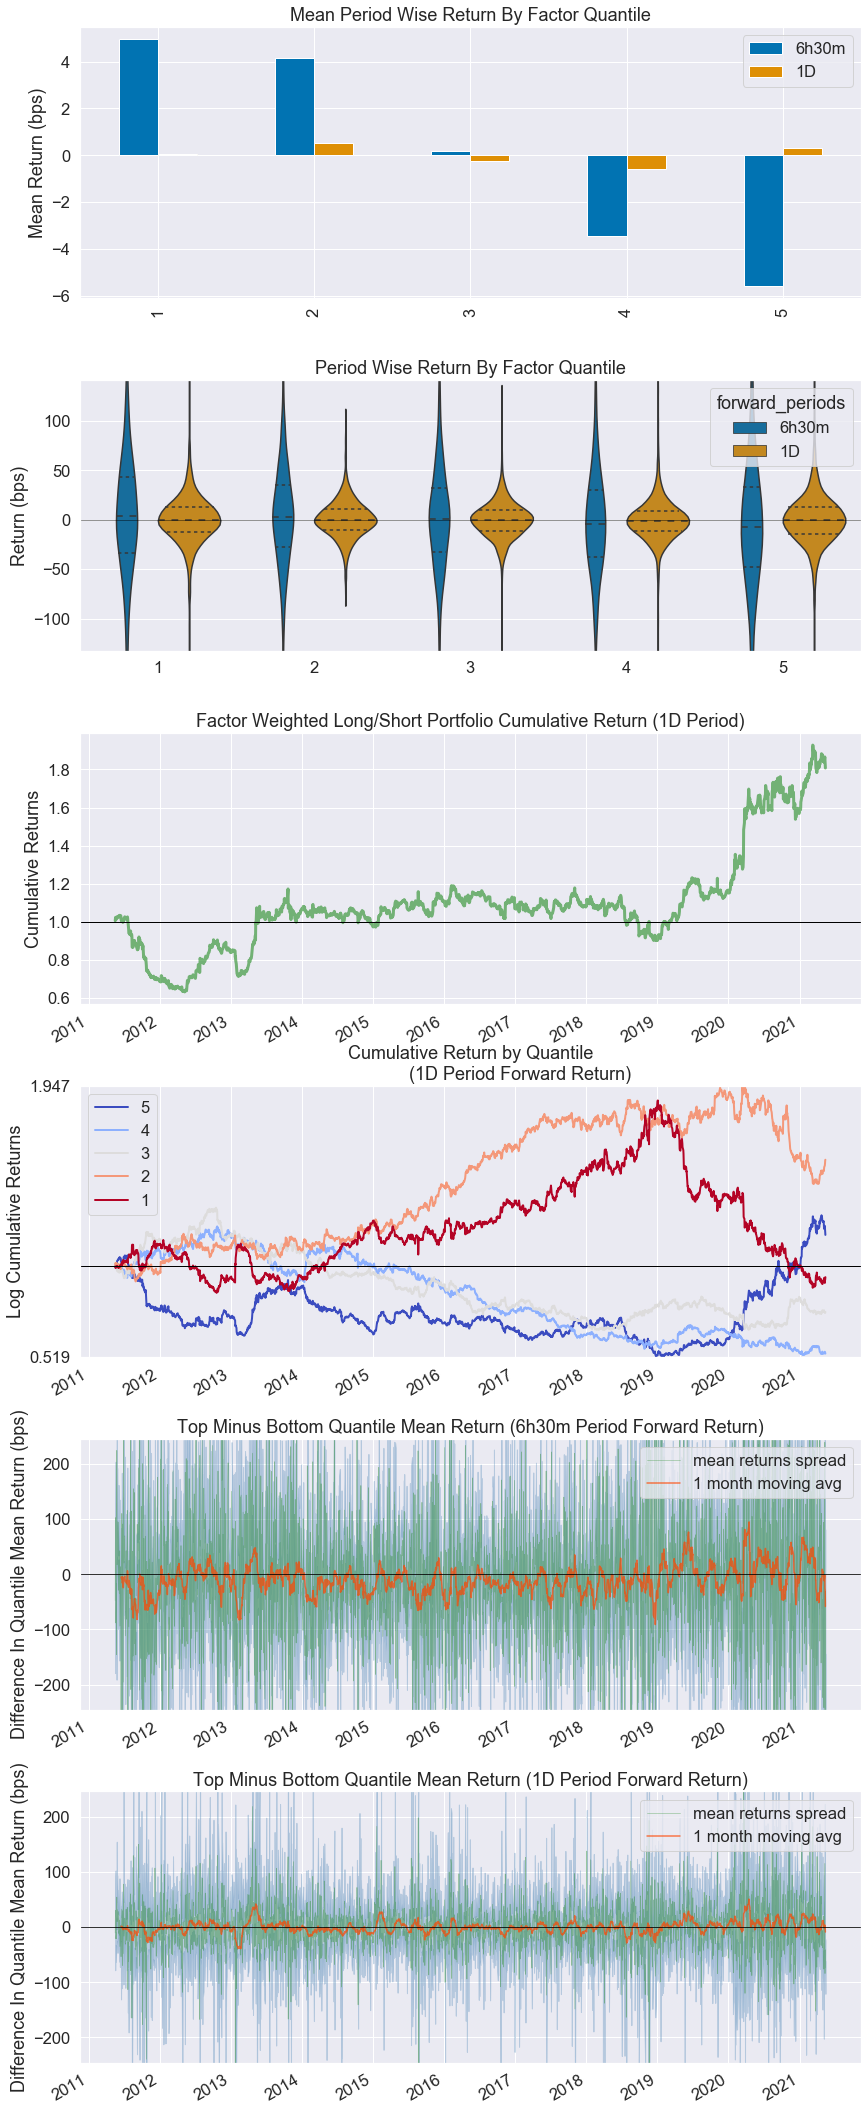

In [17]:
alphalens.tears.create_returns_tear_sheet(non_predictive_factor_data)

<Figure size 432x288 with 0 Axes>

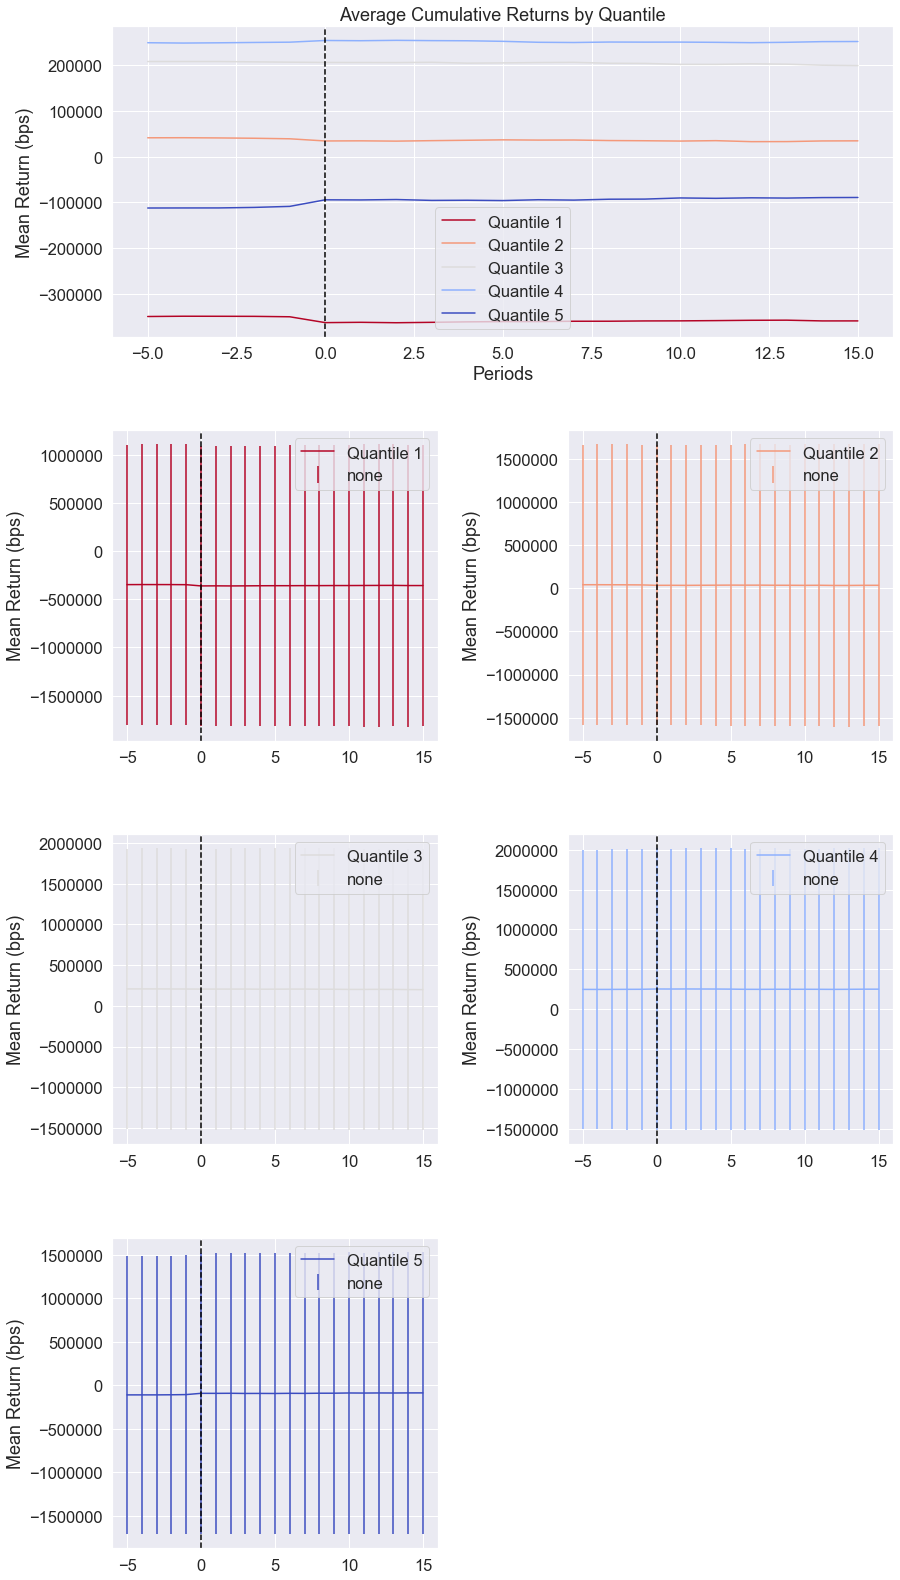

In [18]:
alphalens.tears.create_event_returns_tear_sheet(non_predictive_factor_data, pricing)